In [1]:
from lib.generator import generate_binary_signal, plot_binary_signal
from lib.channel import apply_channel
from lib.receiver import sample_and_detect_nrz
from lib.metrics import ber, shannon_capacity
from lib.ui import create_channel_ui, create_generator_ui, create_receiver_ui
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np


signal_state = {}



In [2]:
def interactive_generator(Rb, frame_length, seed):
    bits, nrz, t, fs, Rb_used = generate_binary_signal(
        Rb=int(Rb),
        frame_length=int(frame_length),
        seed=int(seed)
    )

    # aktualizace sdíleného stavu
    signal_state["bits"] = bits
    signal_state["nrz"] = nrz
    signal_state["t"] = t
    signal_state["fs"] = fs
    signal_state["Rb"] = Rb_used

    plot_binary_signal(bits, nrz, t, Rb_used)

In [3]:
gen_ui, gen_controls = create_generator_ui()

gen_out = widgets.interactive_output(
    interactive_generator,
    gen_controls
)

display(gen_ui, gen_out)


Output()

In [4]:
def interactive_channel(B, snr_db, awgn_on, zoom_bits, show_noise):
    if "nrz" not in signal_state:
        print("⚠️ Nejprve vygeneruj signál")
        return

    nrz = signal_state["nrz"]
    t = signal_state["t"]
    fs = signal_state["fs"]
    Rb = signal_state["Rb"]

    channel_out = apply_channel(
        signal=nrz,
        fs=fs,
        B=float(B),
        snr_db=float(snr_db),
        awgn_on=awgn_on
    )

    samples_per_bit = int(fs / Rb)
    N = zoom_bits * samples_per_bit

    plt.figure(figsize=(12, 4))
    plt.step(t[:N], nrz[:N], where="post", color="#1f4aa8", linewidth=2.5, alpha=0.4, label="NRZ")
    plt.step(t[:N], channel_out[:N], where="post", color="#2E7D32", linewidth=1.5, label="Po kanálu")

    if awgn_on and show_noise:
        noise = channel_out - nrz
        plt.step(t[:N], noise[:N], where="post", color="#7FBF7F", linewidth=0.5, label="Šum")

    plt.xlabel("Čas [s]")
    plt.ylabel("Amplituda")
    plt.title("Kanál: LPF + AWGN")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    signal_state["channel_out"] = channel_out
    signal_state["B"] = B
    signal_state["snr_db"] = snr_db





In [5]:
channel_ui, channel_controls = create_channel_ui()

channel_out = widgets.interactive_output(
    interactive_channel,
    channel_controls
)

display(channel_ui, channel_out)



Output()

In [6]:
def interactive_receiver(enable_adc, fs_rx, zoom_bits):
    if "nrz" not in signal_state or "channel_out" not in signal_state:
        print("⚠️ Nejprve vygeneruj signál a aplikuj kanál")
        return

    # =======================
    # Data ze sdíleného stavu
    # =======================
    nrz_tx = signal_state["nrz"]
    t_tx = signal_state["t"]
    signal = signal_state["channel_out"]

    fs = signal_state["fs"]
    Rb = signal_state["Rb"]

    fs_rx_val = fs_rx if enable_adc else fs

    # =======================
    # Receiver (ADC + detekce)
    # =======================
    bits_rx, _, signal_rx, fs_eff = sample_and_detect_nrz(
        signal,
        fs_internal=fs,
        Rb=Rb,
        fs_rx=fs_rx_val
    )

    signal_state["bits_rx"] = bits_rx

    t_rx = np.arange(len(signal_rx)) / fs_eff

    # =======================
    # Rekonstrukce (ZOH DAC)
    # =======================
    # Rekonstrukce se dělá ZE SIGNÁLU PO ADC (signal_rx)
    t_rec = t_tx
    signal_rec = np.zeros_like(t_rec)

    idx = 0
    for i, t in enumerate(t_rec):
        while idx + 1 < len(t_rx) and t_rx[idx + 1] <= t:
            idx += 1
        signal_rec[i] = signal_rx[idx]

    # =======================
    # ZOOM (v bitech)
    # =======================
    samples_per_bit = int(fs / Rb)
    N_tx = min(len(nrz_tx), zoom_bits * samples_per_bit)

    duration = N_tx / fs
    N_rx = min(len(signal_rx), int(duration * fs_eff))
    N_rec = N_tx

    # =======================
    # Vykreslení
    # =======================
    plt.figure(figsize=(12, 4))

    # Vyslaný NRZ
    plt.step(
        t_tx[:N_tx],
        nrz_tx[:N_tx],
        where="post",
        color="#1f4aa8",
        linewidth=2.5,
        alpha=0.3,
        label="Vyslaný NRZ"
    )

    # Signál po kanálu + ADC
    plt.step(
        t_rx[:N_rx],
        signal_rx[:N_rx],
        where="post",
        color="C1",
        linewidth=1.5,
        label="Po kanálu + ADC"
    )

    # Rekonstruovaný signál (ZOH)
    plt.step(
        t_rec[:N_rec],
        signal_rec[:N_rec],
        where="post",
        color="#6A1B9A",
        linewidth=1.5,
        alpha=0.9,
        label="Rekonstruovaný signál (ZOH)"
    )

    aliasing = fs_eff < 2 * signal_state.get("B", 0)
    title = f"Přijímač + rekonstrukce (fs_rx = {fs_eff/1e3:.1f} kHz)"
    if aliasing:
        title += " – ALIASING"

    plt.title(title)
    plt.xlabel("Čas [s]")
    plt.ylabel("Amplituda")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Output()

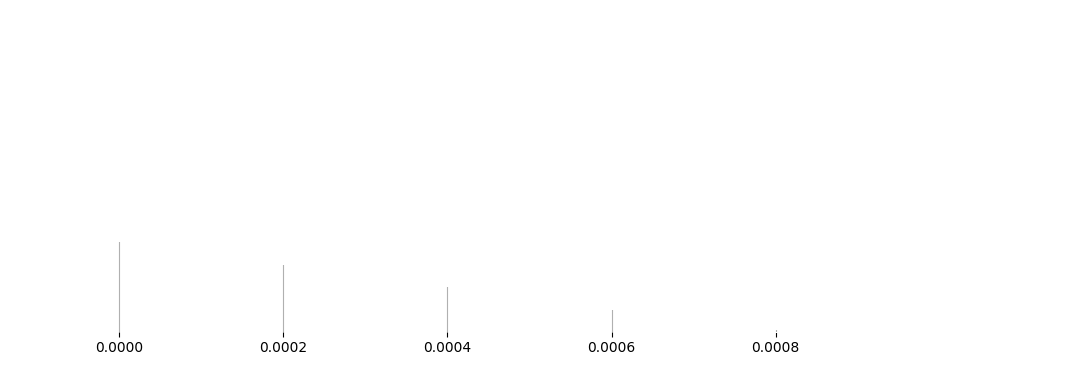

In [8]:
rx_ui, rx_controls = create_receiver_ui()

rx_out = widgets.interactive_output(
    interactive_receiver,
    rx_controls
)

display(rx_ui, rx_out)

# 👇 JEDNORÁZOVÝ INIT
interactive_receiver(
    enable_adc=rx_controls["enable_adc"].value,
    fs_rx=rx_controls["fs_rx"].value,
    zoom_bits=rx_controls["zoom_bits"].value
)

In [9]:
def show_metrics():
    if "bits" not in signal_state or "bits_rx" not in signal_state:
        print("⚠️ Nejsou k dispozici bity pro výpočet BER")
        return

    bits_tx = signal_state["bits"]
    bits_rx = signal_state["bits_rx"]

    ber_value = ber(bits_tx, bits_rx)

    B = signal_state.get("B", None)
    snr_db = signal_state.get("snr_db", None)

    print("📊 METRIKY PŘENOSU")
    print("------------------")
    print(f"BER = {ber_value:.3e}")

    if B is not None and snr_db is not None:
        C = shannon_capacity(B, snr_db)
        print(f"Shannonova kapacita C = {C/1e3:.1f} kb/s")
        print(f"Bitová rychlost Rb = {signal_state['Rb']/1e3:.1f} kb/s")

        if signal_state["Rb"] < C:
            print("✔️ Přenos je teoreticky možný")
        else:
            print("❌ Přenos překračuje Shannonovu kapacitu")


In [10]:
def plot_ber_vs_snr(
    snr_db_range=np.arange(-5, 31, 2),
    fs_rx=None
):
    if "nrz" not in signal_state:
        print("⚠️ Nejprve vygeneruj signál")
        return

    bits_tx = signal_state["bits"]
    nrz = signal_state["nrz"]
    fs = signal_state["fs"]
    Rb = signal_state["Rb"]
    B = signal_state["B"]

    ber_values = []

    for snr_db in snr_db_range:
        # kanál
        rx_signal = apply_channel(
            signal=nrz,
            fs=fs,
            B=B,
            snr_db=snr_db,
            awgn_on=True
        )

        # receiver
        bits_rx, _, _, _ = sample_and_detect_nrz(
            rx_signal,
            fs_internal=fs,
            Rb=Rb,
            fs_rx=fs_rx
        )

        ber_values.append(ber(bits_tx, bits_rx))

    # vykreslení
    plt.figure(figsize=(7, 4))
    plt.semilogy(snr_db_range, ber_values, "o-")
    plt.grid(True, which="both")
    plt.xlabel("SNR [dB]")
    plt.ylabel("BER")
    plt.title("BER vs. SNR")
    plt.tight_layout()
    plt.show()


def plot_ber_vs_fs_rx(
    fs_rx_values=np.logspace(2, 5, 10)  # 100 Hz – 100 kHz
):
    if "nrz" not in signal_state:
        print("⚠️ Nejprve vygeneruj signál")
        return

    bits_tx = signal_state["bits"]
    nrz = signal_state["nrz"]
    fs = signal_state["fs"]
    Rb = signal_state["Rb"]
    B = signal_state["B"]
    snr_db = signal_state["snr_db"]

    ber_values = []

    for fs_rx in fs_rx_values:
        # kanál (pevné SNR)
        rx_signal = apply_channel(
            signal=nrz,
            fs=fs,
            B=B,
            snr_db=snr_db,
            awgn_on=True
        )

        # receiver s omezeným fs_rx
        bits_rx, _, _, _ = sample_and_detect_nrz(
            rx_signal,
            fs_internal=fs,
            Rb=Rb,
            fs_rx=fs_rx
        )

        ber_values.append(ber(bits_tx, bits_rx))

    # vykreslení
    plt.figure(figsize=(7, 4))
    plt.semilogy(fs_rx_values, ber_values, "o-")
    plt.axvline(2 * B, linestyle="--", label="2B (Nyquist)")
    plt.grid(True, which="both")
    plt.xlabel("fs_rx [Hz]")
    plt.ylabel("BER")
    plt.title("BER vs. vzorkovací frekvence přijímače")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [11]:
metrics_out = widgets.Output()
display(metrics_out)

def run_metrics():
    with metrics_out:
        metrics_out.clear_output()
        print("▶️ METRICS SPUŠTĚNY")
        print("Stav signal_state:", list(signal_state.keys()))
        show_metrics()
        plot_ber_vs_snr()
        plot_ber_vs_fs_rx()

eval_button = widgets.Button(
    description="Vyhodnotit přenos",
    button_style="success"
)

eval_button.on_click(lambda _: run_metrics())

display(eval_button)



Output()

Button(button_style='success', description='Vyhodnotit přenos', style=ButtonStyle())